## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np

In [2]:
#1 Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the 
#  maximum number of rows and larger that 10k.

#N = 30000
df = pd.read_table("/mnt/c/Users/ASUS/data/data_000637.txt", sep = ',')#, nrows = N)
print(df)

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1310715     1     0           62  3869211171         762        14
1310716     1     1            4  3869211171         763        11
1310717     1     0           64  3869211171         764         0
1310718     1     0          139  3869211171         769         0
1310719     1     0           61  3869211171         762        18

[1310720 rows x 6 columns]


In [3]:
r, c = df.shape
print("rows", r, "columns", c)

rows 1310720 columns 6


In [4]:
#2 Find out the number of BX in a ORBIT (the value 'x').

df["BX_COUNTER"].max()
df.iat[1,2]

124

In [5]:
#3 Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) 
#  you read, or perform this check precisely by reading out the whole dataset.

x = 3564
c = 30
t = [df.iat[i,3]*x*c+df.iat[i,4]*c+df.iat[i,5] for i in range(len(df))]

In [6]:
ta = np.array(t, dtype = np.float64)
print("The data taking lasted {:.4} TDC_MEAS".format(np.sum(ta)))

The data taking lasted 5.422e+20 TDC_MEAS


In [7]:
#4 Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

abs_time = [x*(5/6) for x in ta]
df.insert(6,"TIME (ns)", abs_time, True)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310716,1,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,1,0,139,3869211171,769,0,3.447467e+14


In [8]:
#5 Replace the values (all 1) of the HEAD column randomly with 0 or 1.

for i in range(len(df)):
    df.iat[i,0] = np.random.randint(0,2)   

In [9]:
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
0,1,0,123,3869200167,2374,26,3.447457e+14
1,0,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,0,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,3.447467e+14
1310716,1,1,4,3869211171,763,11,3.447467e+14
1310717,0,0,64,3869211171,764,0,3.447467e+14
1310718,0,0,139,3869211171,769,0,3.447467e+14


In [10]:
#6 Create a new DataFrame that contains only the rows with HEAD=1.

dfn = df[df.HEAD != 0]
dfn

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
0,1,0,123,3869200167,2374,26,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
...,...,...,...,...,...,...,...
1310710,1,1,36,3869211171,427,13,3.447467e+14
1310712,1,1,35,3869211171,429,4,3.447467e+14
1310713,1,0,64,3869211171,758,18,3.447467e+14
1310714,1,0,60,3869211171,762,2,3.447467e+14


In [11]:
#7 Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

df0 = df[df.FPGA != 1]
df1 = df[df.FPGA != 0]

139 139


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a509cb20>]],
      dtype=object)

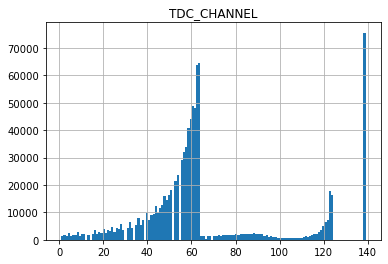

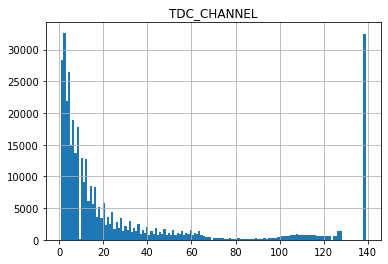

In [12]:
l = df0["TDC_CHANNEL"].max()
h = df1["TDC_CHANNEL"].max()
print(h, l)

%matplotlib inline

df0.hist("TDC_CHANNEL", bins = 140)
df1.hist("TDC_CHANNEL", bins = 140)

In [13]:
#8 Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

u = df.groupby(["TDC_CHANNEL"])
h = []
k = []
for key, item in u: 
    k.append(len(u.get_group(key)))
    h.append((key))
ka = np.array(k)
ha = np.array(h)

ind = ka.argsort()[-3:][::-1]
print(ind)
print(ha[132], ha[63], ha[62])

[132  63  62]
139 64 63


In [14]:
#9 Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

df.drop_duplicates(subset="ORBIT_CNT", keep=False)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
395263,0,0,63,3869204142,3121,15,3.447461e+14
593919,0,0,65,3869206180,3062,9,3.447463e+14
